<a href="https://colab.research.google.com/github/brendanhasz/embedding-regression/blob/master/TFP_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tfp-nightly

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

np.random.seed(1234)
tf.set_random_seed(1234)

# Data

In [0]:
# Generate fake data
D = 4
N = 100
W = np.random.randn(D, 1).astype(np.float32)
x = np.random.randn(N, D).astype(np.float32)
noise = np.random.randn(N, 1).astype(np.float32)
y = np.matmul(x, W) + noise

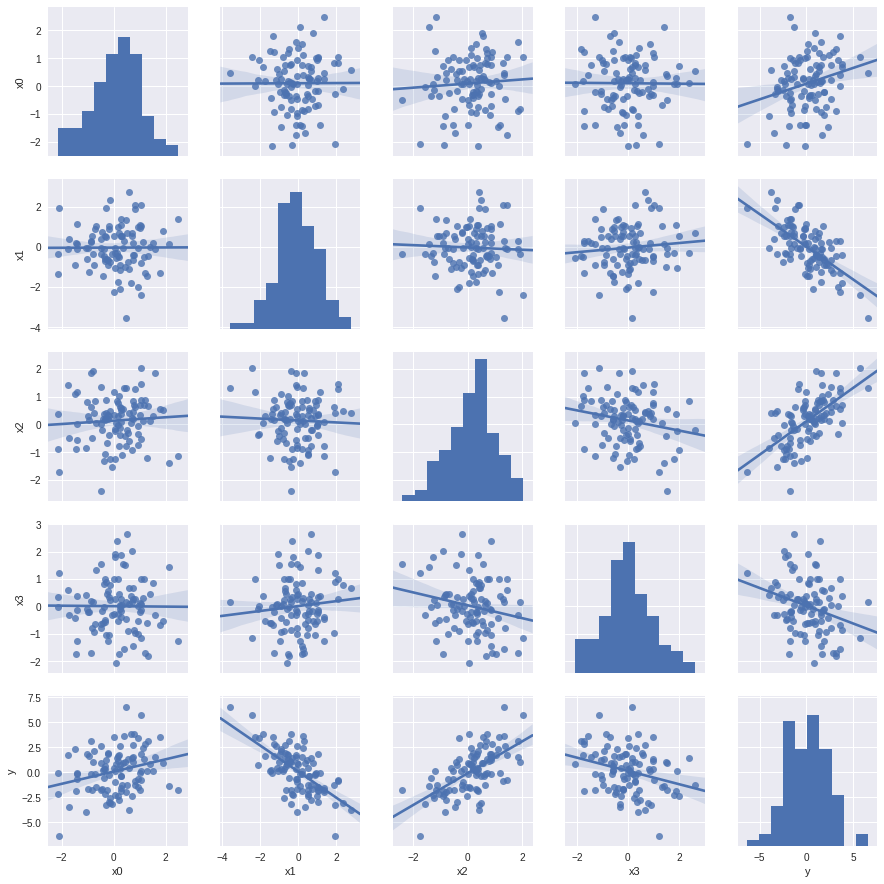

In [4]:
# Show data
cols = ['x0', 'x1', 'x2', 'x3', 'y']
sns.pairplot(pd.DataFrame(np.c_[x, y], columns=cols),
             kind='reg')
plt.show()

# Model

A basic Bayesian linear regression

\begin{align*}
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{HalfNormal}(1) \\
y_i &\sim \text{Normal}(x_i^\top \beta, ~ \sigma^2)
\end{align*}



In [0]:
def linear_regression(features):
  """Bayesian linear regression, which returns predictions given features."""
  D = features.shape[1]
  coeffs = ed.Normal( #normal prior on weights
      loc=tf.zeros([D,1]),
      scale=tf.ones([D,1]),
      name="coeffs")
  noise_std = ed.HalfNormal( #half-normal prior on noise std
      scale=1.,
      name="noise_std")
  predictions = ed.Normal( #normally-distributed noise around predicted values
      loc=tf.matmul(features, coeffs),
      scale=noise_std,
      name="predictions")
  return predictions

log_joint = ed.make_log_joint_fn(linear_regression)

def target_log_prob_fn(coeffs, noise_std):
  """Target density."""
  return log_joint(
      features=x,
      coeffs=coeffs,
      noise_std=noise_std,
      predictions=y)

# Bayesian Inference

Yadda yadda

In [10]:
# HMC Settings
num_results = int(10e3) #number of hmc iterations
n_burnin = int(5e3)
step_size = 0.05 #works w/ 100 datapoints?
num_leapfrog_steps = 2

# Parameter sizes
coeffs_size = [4,1]
noise_std_size = [1]

t0 = time.time()

# HMC transition kernel
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size,
    num_leapfrog_steps=num_leapfrog_steps)

# Run the chain
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    kernel=kernel,
    current_state=[
        tf.zeros(coeffs_size, name='init_coeffs'),
        tf.ones([], name='init_noise_std'),
    ])

coeffs, noise_std = states

with tf.Session() as sess:
  [
      coeffs_,
      noise_std_,
      is_accepted_,
  ] = sess.run([
      coeffs,
      noise_std,
      kernel_results.is_accepted,
  ])


# Remove samples from burn-in
coeffs_samples = coeffs_[n_burnin:,:,0]
noise_std_samples = noise_std_[n_burnin:]
accepted_samples = is_accepted_[n_burnin:]

print('Elapsed time: ', time.time()-t0)

Elapsed time:  6.292583465576172


Talk about acceptance rate.  

Sounds like an acceptance rate of about 0.234 is "optimal".  http://dx.doi.org/10.1214/aoap/1034625254


In [11]:
print('Acceptance rate: ', np.mean(accepted_samples))

Acceptance rate:  0.9278


TODO: talk about looking @ posterior distribution

dist is the posterior, solid line is true val, dotted lines show 95% conf interval

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

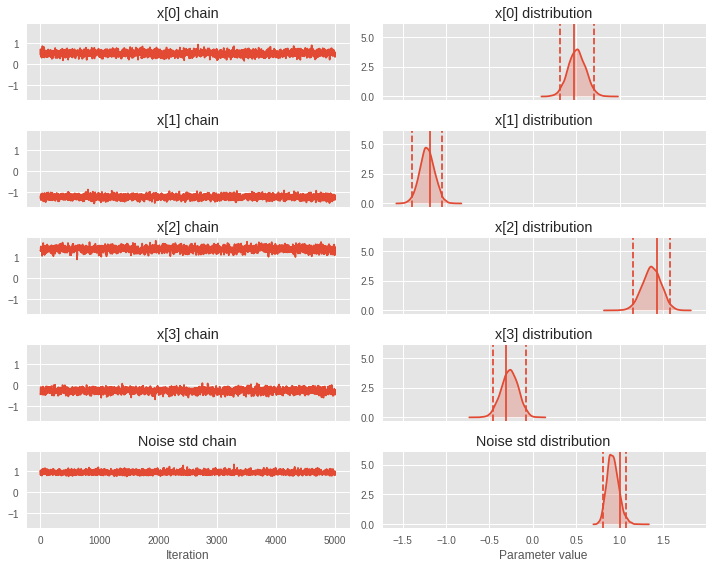

In [12]:
def chain_plot(data, title='', ax=None):
  if ax is None:
    ax = plt.gca()
  ax.plot(data)
  ax.title.set_text(title+" chain")
  
def post_plot(data, title='', ax=None, true=None, prc=95):
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(data, ax=ax, shade=True)
  ax.axvline(x=np.percentile(data, (100-prc)/2), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-(100-prc)/2), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)
    
def chain_post_plot(data, title='', ax=None, true=None):
  chain_plot(data, title=title, ax=ax[0])
  post_plot(data, title=title, ax=ax[1], true=true)
  
# Plot chains and distributions for coefficients
plt.style.use("ggplot")
fig, axes = plt.subplots(5, 2, sharex='col', sharey='col')
fig.set_size_inches(10, 8)
for i in range(4):
  chain_post_plot(coeffs_samples[:,i],
                  title="x[{}]".format(i),
                  ax=axes[i], true=W[i])
  
# and for noise std dev
chain_post_plot(noise_std_samples,
                title="Noise std",
                ax=axes[4], true=1)
  
axes[4][0].set_xlabel("Iteration")
axes[4][1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

# Criticism

TODO

talk math, how you set the param values to the mean of their posterior dists, and then sample from the model, you can see "posterior predictive distributions" (but this is assuming the true params = the mean of the posterior, which the prediction interval above didn't)

Only captures aleatoric (noise) uncertainty.

Generate some held-out data


In [0]:
# Generate held out data
x_val = np.random.randn(N, D).astype(np.float32)
noise = np.random.randn(N, 1).astype(np.float32)
y_val = np.matmul(x_val, W) + noise

then intercept etc

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


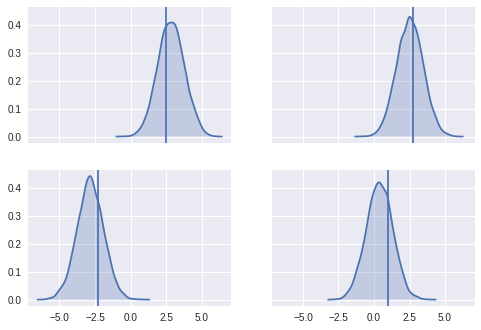

In [16]:
def interceptor(f, *args, **kwargs):
  name = kwargs.pop("name")
  if name == "coeffs":
    kwargs["value"] = np.reshape(np.mean(coeffs_samples, 0), (4,1))
  elif name == "noise_std":
    kwargs["value"] = np.mean(noise_std_samples, 0)
  return f(*args, **kwargs)

with ed.interception(interceptor):
  posterior = linear_regression(features=x_val)

with tf.Session() as sess:
  posterior_predictive = sess.run(
      posterior.distribution.sample(sample_shape=(5000)))

# TODO: ok so this is only showing prediction interval w/ 
# param values = mean posterior value for each param.  So we're only 
# seeing "irreducible" uncertainty and not model uncertainty

# Plot random datapoints and their posterior predictive intervals
sns.set()
fig, axes = plt.subplots(2, 2, sharex='all', sharey='all')
for i in range(2):
  for j in range(2):
    #ix = np.random.randint(0, N)
    ix = i*2+j
    sns.kdeplot(posterior_predictive[:,ix,0], shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])
    vals1 = posterior_predictive[:,ix,0]

TODO: then you can take the mean of the posterior predictive for each datapoint and plot the residuals.  In theory the residual distribution should look like the distribution you used to model the noise (in our case a normal distribution)

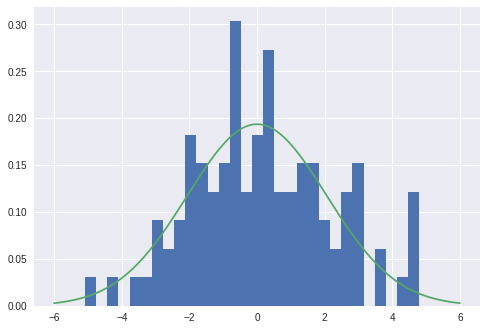

In [17]:
# Compute the mean posterior predictive for each datapoint
with tf.Session() as sess:
  residuals = sess.run(
      posterior.distribution.mean())
  #tho technically you want to generate posterior samples, and take the means of those...
  
# Plot the residual distribution
plt.figure()
#sns.kdeplot(residuals[:,0])
plt.hist(residuals[:,0], bins=30, density=True)
xx = np.linspace(-6, 6, 200)
plt.plot(xx, norm.pdf(xx, scale=np.std(residuals)))
plt.show()

In [49]:
np.std(residuals)

1.8646088

Hmm well it's not looking super normal... May want to relax the normal dist assumptions, perhaps use a t-distribution...

# Prediction intervals


TODO (generate prediction intervals for test data)

Captures both epistemic (model) + aleatoric (noise) uncertainty

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


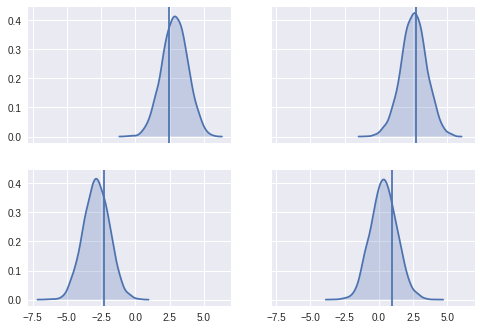

In [18]:
def prediction_distribution(X):
  # seems like there should be a way to do this like:
  #posterior = linear_regression(features=np.reshape(X, (len(X), 1)))
  #define param posterior vals somehow?
  # trying to do it w/ interceptor doesn't work, unless you change the interceptor and get a single sample each time...
  #with tf.Session() as sess:
  #  prediction_samples = sess.run(posterior.distribution.sample(sample_shape=(n)))  
  predictions = np.matmul(X, coeffs_samples.transpose())
  noise = noise_std_samples*np.random.randn(noise_std_samples.shape[0])
  return predictions + noise

# Plot random datapoints and their prediction intervals
sns.set()
fig, axes = plt.subplots(2, 2, sharex='all', sharey='all')
for i in range(2):
  for j in range(2):
    #ix = np.random.randint(0, N)
    ix = i*2+j
    pred_dist = prediction_distribution(x_val[ix,:])
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix,0])
    vals2 = pred_dist

# Bayeisan Nnet

cant do MCMC, variational

First we'll test a super-simple network to ensure that it captures uncertainties correctly.


\begin{align*}
y             &=      \beta x + \epsilon \\
\beta      &\sim \text{Normal}(2, 1) \\
\epsilon &\sim \text{Normal}(0, 1) \\
\end{align*}


In [0]:
#TODO: TWO BAYESIAN NEURAL NETS, ONE predicts mean and the other predicts variance?
# fast_kde func which can do kde via lookup? for plotting the prediction intervals
# if you sample mu and sigma from the two bayesian neural nets
# then generate kde w/ mu + sigma for each sample

# TODO: EMBEDDING W/ THE LINEAR MODEL + W/ BAYESIAN NEURAL NETS
# but... With a 1dim embedding + a linear model, that's the same as a random effect? 
# And with regression you could do a >1 dim embedding, but if you're doing mcmc 
# the posterior will be super multimodal (same problem as trying to fit a hmm w hmc), 
# but will be ok with optimising.  
# Maybe use variational inf?  but dunno if that would try to capture all possible modes
# could also, just do optimizing, then set prior on embeddings = prod of normal prior
# and gaussian @ the embedding value found w/ optimizing?
# that would probs help keep the MCMC samples unimodal
# should test to see whether variational inf finds a single mode or tries to stretch
# the variational distribution over multiple modes

# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py
# https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout
  
  
# TODO: first just do a simple fit w/ 1 weight so ensure that flipout estimator
# accurately estimates weight distribution

In [0]:
!pip install -q tfp-nightly

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

np.random.seed(1234)
tf.set_random_seed(1234)


In [5]:
# Settings 
learning_rate = 0.001
batch_size = 128

# Generate fake data
D = 4
N = 100
W = np.random.randn(D, 1).astype(np.float32)
x = np.random.randn(N, D).astype(np.float32)
noise = np.random.randn(N, 1).astype(np.float32)
y = np.matmul(x, W) + noise

print(W)

[[ 0.47143516]
 [-1.1909757 ]
 [ 1.432707  ]
 [-0.3126519 ]]


In [20]:
def input_pipeline(x_all, y_all, batch_size):
  tr_data = tf.data.Dataset.from_tensor_slices((x_all, y_all))
  tr_batches = tr_data.shuffle(N*10).repeat().batch(batch_size)
  tr_iterator = tr_batches.make_one_shot_iterator()
  x_train, y_train = tr_iterator.get_next()
  return x_train, y_train

x_train, y_train = input_pipeline(x, y, batch_size)

# Construct the single-unit neural "net"
with tf.name_scope('simple_bayesian_net', values=[x_train]):
  nnet = tfp.layers.DenseFlipout(
      units=1, 
      activation=None,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn()) 
  #noise_scale = tf.get_variable("noise_scale", [1])
  #noise_scale = ed.HalfNormal(scale=1, name='noise_scale')
  predictions = nnet(x_train)
  value_distribution = tfd.Normal( #normally-distributed noise around predicted values
    loc=predictions,
    scale=1., #scale=noise_scale,
    name='value_distribution')

# Compute the -ELBO
neg_log_likelihood = -tf.reduce_mean(value_distribution.log_prob(x_train))
kl_div = sum(nnet.losses) / float(N)
elbo_loss = neg_log_likelihood + kl_div

# Evaluation metrics
mse, mse_update_op = tf.metrics.mean_squared_error(y_train, predictions)


with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(elbo_loss)
  
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [21]:
# Extract weight posteriors @ each training iteration
qmean = nnet.kernel_posterior.mean()
qstd = nnet.kernel_posterior.stddev()
bmean = nnet.bias_posterior.mean()
bstd = nnet.bias_posterior.stddev()
qmeans = []
qstds = []
bmeans = []
bstds = []
noise_stds = []
kl_divs = []
nlls = []
mses = []

# Train
Nt = 1000
with tf.Session() as sess:
  sess.run(init_op)
  
  for step in range(Nt):
    _, t_kl, t_nll, t_mse = sess.run(
        [train_op, kl_div, neg_log_likelihood, mse_update_op])
    
    t_qmean, t_qstd, t_bmean, t_bstd = sess.run((qmean, qstd, bmean, bstd))
    #t_ns = noise_scale.eval(sess)
    
    qmeans.append(t_qmean)
    qstds.append(t_qstd)    
    bmeans.append(t_bmean[0])
    bstds.append(t_bstd[0])
    #noise_stds.append(t_ns)
    kl_divs.append(t_kl)
    nlls.append(t_nll)
    mses.append(t_mse)
    
    if step % 100 == 0:
      print("Step: {:>3d} Loss: {:.3f} MSE: {:.3f}".format(
            step, t_kl+t_nll, t_mse))

  # Get draws from posterior
  Nmc = 1000
  w_draw = nnet.kernel_posterior.sample(Nmc)
  b_draw = nnet.bias_posterior.sample(Nmc)
  w_post, b_post = sess.run([w_draw, b_draw])

Step:   0 Loss: 1.475 MSE: 5.044
Step: 100 Loss: 1.484 MSE: 4.713
Step: 200 Loss: 1.490 MSE: 4.737
Step: 300 Loss: 1.502 MSE: 4.762
Step: 400 Loss: 1.477 MSE: 4.776
Step: 500 Loss: 1.488 MSE: 4.789
Step: 600 Loss: 1.484 MSE: 4.798
Step: 700 Loss: 1.503 MSE: 4.802
Step: 800 Loss: 1.495 MSE: 4.808
Step: 900 Loss: 1.470 MSE: 4.815


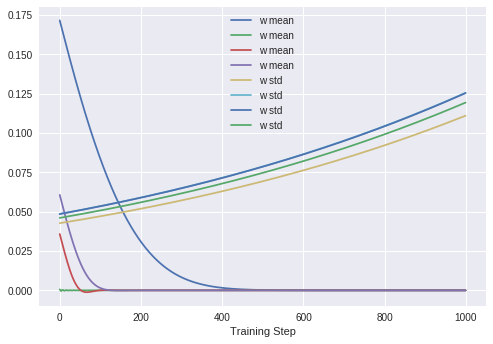

In [22]:
# Plot weights over training iterations
plt.figure
plt.plot(np.array(qmeans)[:,:,0], label='w mean')
plt.plot(np.array(qstds)[:,:,0], label='w std')
plt.xlabel('Training Step')
plt.legend()
plt.show()

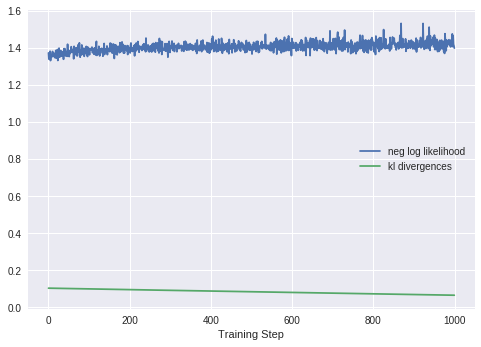

In [23]:
# Plot losses over training iterations
plt.plot(nlls, label='neg log likelihood')
plt.plot(kl_divs, label='kl divergences')
plt.xlabel('Training Step')
plt.legend()
plt.show()

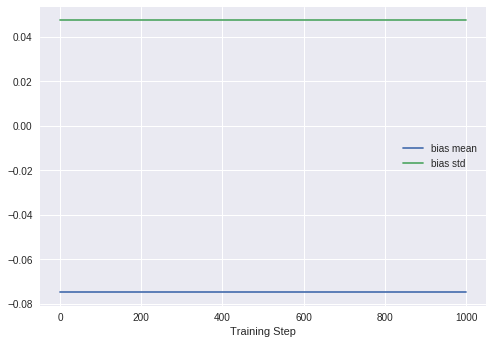

In [24]:
plt.plot(bmeans, label='bias mean')
plt.plot(bstds, label='bias std')
plt.xlabel('Training Step')
plt.legend()
plt.show()

and we can look at posterior samples

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


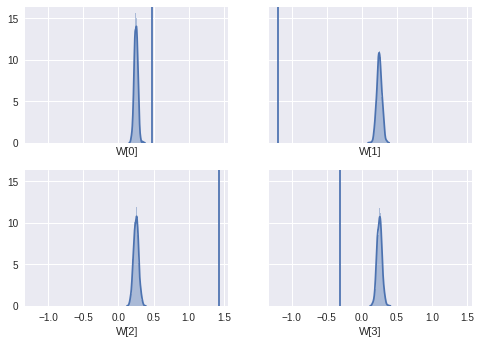

In [18]:
# Plot weight posteriors
sns.set()
fig, axes = plt.subplots(2, 2, sharex='all', sharey='all')
for i in range(2):
  for j in range(2):
    k = 2*i+j
    sns.distplot(w_post[:,k,0], ax=axes[i][j])
    axes[i][j].axvline(x=W[k,0])
    axes[i][j].set_xlabel('W[{}]'.format(k))
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


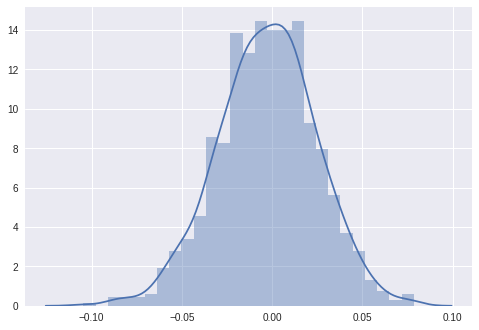

In [19]:
# Plot bias posterior
sns.distplot(b_post)
plt.show()

Doesn't seem to be working... does it work w/ another example?

In [39]:
def toy_logistic_data(num_examples, input_size=2, weights_prior_stddev=5.0):
  """Generates synthetic data for binary classification.
  Args:
    num_examples: The number of samples to generate (scalar Python `int`).
    input_size: The input space dimension (scalar Python `int`).
    weights_prior_stddev: The prior standard deviation of the weight
      vector. (scalar Python `float`).
  Returns:
    random_weights: Sampled weights as a Numpy `array` of shape
      `[input_size]`.
    random_bias: Sampled bias as a scalar Python `float`.
    design_matrix: Points sampled uniformly from the cube `[-1,
       1]^{input_size}`, as a Numpy `array` of shape `(num_examples,
       input_size)`.
    labels: Labels sampled from the logistic model `p(label=1) =
      logistic(dot(features, random_weights) + random_bias)`, as a Numpy
      `int32` `array` of shape `(num_examples, 1)`.
  """
  random_weights = weights_prior_stddev * np.random.randn(input_size)
  random_bias = np.random.randn()
  design_matrix = np.random.rand(num_examples, input_size) * 2 - 1
  logits = np.reshape(
      np.dot(design_matrix, random_weights) + random_bias,
      (-1, 1))
  p_labels = 1. / (1 + np.exp(-logits))
  labels = np.int32(p_labels > np.random.rand(num_examples, 1))
  return random_weights, random_bias, np.float32(design_matrix), labels

def build_input_pipeline(x, y, batch_size):
  """Build a Dataset iterator for supervised classification.
  Args:
    x: Numpy `array` of features, indexed by the first dimension.
    y: Numpy `array` of labels, with the same first dimension as `x`.
    batch_size: Number of elements in each training batch.
  Returns:
    batch_features: `Tensor` feed  features, of shape
      `[batch_size] + x.shape[1:]`.
    batch_labels: `Tensor` feed of labels, of shape
      `[batch_size] + y.shape[1:]`.
  """
  training_dataset = tf.data.Dataset.from_tensor_slices((x, y))
  training_batches = training_dataset.repeat().batch(batch_size)
  training_iterator = training_batches.make_one_shot_iterator()
  batch_features, batch_labels = training_iterator.get_next()
  return batch_features, batch_labels




# Generate (and visualize) a toy classification dataset.
N = 1000
batch_size = 128
max_steps = 1500
learning_rate = 0.01
w_true, b_true, x, y = toy_logistic_data(N, 3, 1)
features, labels = build_input_pipeline(x, y, batch_size)

# Define a logistic regression model as a Bernoulli distribution
# parameterized by logits from a single linear layer. We use the Flipout
# Monte Carlo estimator for the layer: this enables lower variance
# stochastic gradients than naive reparameterization.
with tf.name_scope("logistic_regression", values=[features]):
  layer = tfp.layers.DenseFlipout(
      units=1,
      activation=None,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn())
  logits = layer(features)
  labels_distribution = tfd.Bernoulli(logits=logits)

# Compute the -ELBO as the loss, averaged over the batch size.
neg_log_likelihood = -tf.reduce_mean(labels_distribution.log_prob(labels))
kl = sum(layer.losses) / N
elbo_loss = neg_log_likelihood + kl

# Build metrics for evaluation. Predictions are formed from a single forward
# pass of the probabilistic layers. They are cheap but noisy predictions.
predictions = tf.cast(logits > 0, dtype=tf.int32)
accuracy, accuracy_update_op = tf.metrics.accuracy(
    labels=labels, predictions=predictions)

with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(elbo_loss)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
  sess.run(init_op)

  # Fit the model to data.
  for step in range(max_steps):
    _ = sess.run([train_op, accuracy_update_op])

  # Visualize some draws from the weights posterior.
  Nmc = 1000
  w_draw = layer.kernel_posterior.sample(Nmc)
  b_draw = layer.bias_posterior.sample(Nmc)
  w_post, b_post = sess.run([w_draw, b_draw])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [37]:
w_true.shape

(3,)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


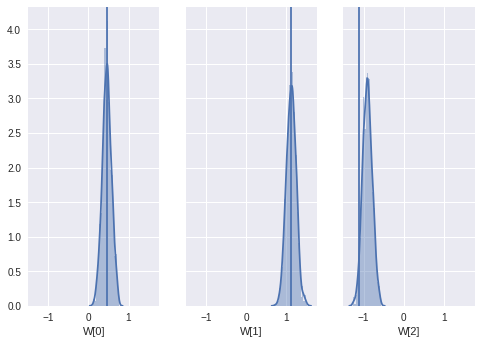

In [40]:
# Plot weight posteriors
sns.set()
Nsp = len(w_true)
fig, axes = plt.subplots(1, Nsp, sharex='all', sharey='all')
for i in range(Nsp):
  sns.distplot(w_post[:,i,0], ax=axes[i])
  axes[i].axvline(x=w_true[i])
  axes[i].set_xlabel('W[{}]'.format(i))
plt.show()